In [1]:
# Add local scripts to module search path
import sys
import os
sys.path.append(os.path.realpath('../toliman-proper'))

In [52]:
prescription_vals = {
                    # Eduardo's values:
                    'diam': 0.001 * 2. * 150, 
                    'm1_fl': 0.5717255, 
                    'm1_m2_sep': 0.54933763033373, 
                    'm2_fl': -0.02337895948640,  
                    'bfl': 0.52761,#0.58999999998985,  
                    'm2_rad': 0.00590401477581,
                    'm1_conic': -1.00011470000000,
                    'm2_conic': -1.16799179177759,
                    # Go for 5-fold symmetry to match assumed rosette
                    'm2_strut_width': 0.01,
                    'm2_supports': 5,
                    'noabs': True,
                    'beam_ratio': 0.2,
                    'tilt_x': 0.00,
                    'tilt_y': 0.00
}

tilts = [0., 7.2, 50] # arcsecs

gridsize = 2048
nrows=len(tilts)
hwidth = 256
off_x = int(gridsize/2) -hwidth
off_y = int(gridsize/2) -hwidth
npix = 2*hwidth


In [53]:
import proper
def gen_tilted_psfs(prescription,
                    prescription_vals,
                    tilts_x,
                    tilts_y,
                    wavelength = 0.6,
                    gridsize = 2048):
    wavefronts = []
    samplings = []
    for dx in tilts_x:
        for dy in tilts_y:
            prescription_vals['tilt_x'] = dx
            prescription_vals['tilt_y'] = dy
            (wavefront, sampling) = proper.prop_run(prescription, wavelength, gridsize, QUIET=True, VERBOSE=False, PRINT_INTENSITY=False, PASSVALUE=prescription_vals)
            wavefronts.append(wavefront)
            samplings.append(sampling)
    return (wavefronts, samplings)

In [54]:
(conic_wfs, conic_samps) = gen_tilted_psfs('prescription_rc_conic', prescription_vals, tilts, [0.])
(quad_wfs, quad_samps) = gen_tilted_psfs('prescription_rc_quad', prescription_vals, tilts, [0.])


Lambda = 6.0000E-07   Throughput = 1.00
Applying lens at primary
  LENS: Gaussian R_beam_old = Infinite    R_beam =  -0.5717255
  LENS: propagator_type =  INSIDE__to_OUTSIDE
  LENS: R beam old = Infinite  R_beam = -0.5717254999865352  lens_fl =  0.572
  LENS: Beam diameter at lens = 0.300
  LENS: Rayleigh distance = 0.000002774559
Propagating to secondary
  PROPAGATOR: propagator_type = OUTSIDE_to_OUTSIDE
  STW: dz = 0.571725
 FFT2 prop_stw   
  STW: z = 0.571725    dx = 2.286902e-07
  WTS: dz =  -0.02238786965280526
IFF2t prop_wts  
  WTS: z =  0.54933763033373   dx =  2.8680486472528164e-05
Total intensity at surface  secondary  =  1.0
Applying lens at secondary
  LENS: Gaussian R_beam_old =  -0.022387869996660145   R_beam =  -0.5281108427212667
  LENS: propagator_type =  OUTSIDE_to_OUTSIDE
  LENS: R beam old = -0.02238786965280526  R_beam = -0.5281063292735114  lens_fl = -0.023
  LENS: Beam diameter at lens = 0.012
  LENS: 1/lens_fl =  -42.77350326825792
  LENS: 1/R_beam_old =  -44.

  LENS: Rayleigh distance = 0.001543884816
Propagating to focus
  PROPAGATOR: propagator_type = OUTSIDE_to_INSIDE_
  STW: dz = 0.528106
 FFT2 prop_stw   
  STW: z = 1.077444    dx = 5.394562e-06
  PTP: dz =  -0.0004963292735113978
 FFT2 prop_ptp  
 IFFT2 prop_ptp  
  PTP: z =  1.07694763033373   dx =  5.3945616055901824e-06
Total intensity at surface  focus  =  1.0
Total elapsed time (seconds) =   7.5252


In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def plot_psf_diff(conic_wfs, quad_wfs, cx, cy, off_x,
                npix = 80):
    ncols = int(len(conic_wfs))
    hx = int(npix/2)
    cx -= hx
    cy -= hx
    norm = LogNorm(vmin=1e-7, vmax=1e-2)
    fig, axes = plt.subplots(nrows=3, ncols=ncols, sharex=True, sharey=True, figsize=(12,10), squeeze=False)
    for wf, ax, dx in zip(conic_wfs, axes[0], off_x):
        im = ax.imshow(np.abs(wf[cx+dx:cx+dx+npix, cy:cy+npix])**2, interpolation = 'none', cmap='viridis', norm=norm)
        fig.colorbar(im, ax=ax)
    for wf, ax, dx in zip(quad_wfs, axes[1], off_x):
        im = ax.imshow(np.abs(wf[cx+dx:cx+dx+npix, cy:cy+npix])**2, interpolation = 'none', cmap='viridis',norm=norm)
        fig.colorbar(im, ax=ax)
    for conic, quad, ax, dx in zip(conic_wfs, quad_wfs, axes[2], off_x):
        im = ax.imshow(np.abs(conic[cx+dx:cx+dx+npix, cy:cy+npix] - quad[cx+dx:cx+dx+npix, cy:cy+npix])**2, interpolation = 'none', cmap='jet')#, norm=LogNorm(vmin=0.01, vmax=1))
        fig.colorbar(im, ax=ax)
    plt.show()

5.3945616055901824e-06 13750.987083139758 [0.0, 7.2, 50] 0.08271130985780459 [0, 87, 604]


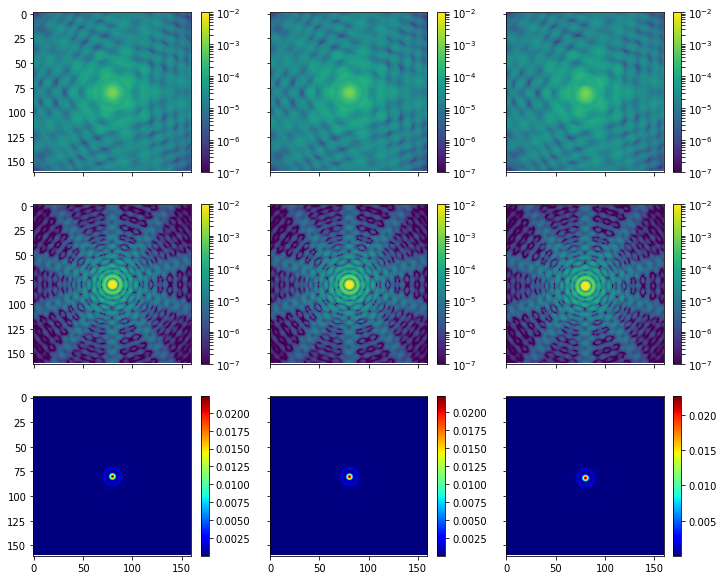

In [81]:
%matplotlib inline
hw = int(gridsize/2)
efl = 15
sample_m = conic_samps[0] # m/pixel
as_per_m = 360*3600/(2.*np.pi*efl)
s= 1.115*sample_m*as_per_m # Doesn't seem quite right - maybe the EFL is a bit off
#print(sample_m, as_per_m, tilts, s, [int(x/s) for x in tilts])
plot_psf_diff(conic_wfs, quad_wfs, hw, hw, [int(x/s) for x in tilts], npix = 160)
